In [ ]:
%cd ..

In [1]:
# type: ignore

from __future__ import annotations

import typing
from typing import Literal, cast, TypeVar
from pathlib import Path
from datetime import timedelta
from dataclasses import dataclass
from itertools import groupby, pairwise
from collections.abc import Iterable

from datasets import load_dataset, Audio, load_from_disk # type: ignore
import gigaam
from gigaam.model import GigaAMASR
import soundfile as sf
from tqdm.auto import tqdm
import srt
import torch
import numpy as np
import numpy.typing as npt
from torchaudio.transforms import Resample
import matplotlib.pyplot as plt
from IPython.display import Audio

from asr_eval.datasets.recording import Recording
from asr_eval.align.data import Token, MultiVariant, Anything
from asr_eval.models.gigaam import encode, decode, transcribe_with_gigaam_ctc, GigaAMEncodeError, FREQ
from asr_eval.align.timings import get_word_timings_simple, fill_word_timings_inplace
from asr_eval.utils.srt import utterances_to_srt
from asr_eval.utils.misc import groupby_into_spans
from asr_eval.align.parsing import parse_multivariant_string, colorize_parsed_string
from asr_eval.ctc.forced_alignment import forced_alignment
from asr_eval.align.plots import draw_timed_transcription
from asr_eval.align.recursive import select_shortest_multi_variants
from asr_eval.streaming.models.vosk import VoskStreaming
from asr_eval.streaming.evaluation import default_evaluation_pipeline
from asr_eval.streaming.plots import (
    partial_alignments_plot,
    visualize_history,
    streaming_error_vs_latency_histogram,
    latency_plot,
    show_last_alignments,
)

In [2]:
model = typing.cast(GigaAMASR, gigaam.load_model('ctc', device='cuda'))

/home/oleg/asr-eval/venv/lib/python3.12/site-packages/gigaam/__init__.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=

In [3]:
# # type: ignore

# datasets = {
#     'podlodka': (
#         load_dataset('bond005/podlodka_speech')['test']
#         .cast_column("audio", Audio(sampling_rate=16_000))
#         .take(20)
#     ),
#     'golos_farfield': (
#         load_dataset('bond005/sberdevices_golos_100h_farfield')['test']
#         .cast_column("audio", Audio(sampling_rate=16_000))
#         .take(20)
#     ),
# }

# for dataset_name, dataset in datasets.items():
#     dir = Path(f'srt/{dataset_name}')
#     dir.mkdir(exist_ok=True, parents=True)
#     for sample_idx, sample in tqdm(enumerate(dataset)):
#         waveform = sample['audio']['array']
#         text = sample['transcription']
#         text = text.lower().replace('ё', 'е').replace('-', ' ')
#         for char in ('.', ',', '!', '?', ';', ':', '"', '(', ')'):
#             text = text.replace(char, '')
#         try:
#             encode(model, text)
#         except ValueError:
#             print(f'Cannot encode: {text}')
#             continue
#         timings = get_word_timings(model, waveform, text)
#         (dir / f'{sample_idx}.srt').write_text(utterances_to_srt(timings))
#         sf.write(dir / f'{sample_idx}.wav', waveform, samplerate=16_000)
#         break

In [4]:
# dataset = load_from_disk('tmp/multivariate/multivariant_v1_200')

# sample = dataset[70] # type: ignore

# waveform = Resample(22050, 16000, dtype=torch.float64)(
#     torch.tensor(np.array(sample['audio']['array'])) # type: ignore
# ).numpy()

# blocks = [
#     x
#     for x in srt.parse(sample['trans']) # type: ignore
#     if x.end < timedelta(seconds=60)
# ]

# finish_time = blocks[-1].end.total_seconds()
# waveform = waveform[:int(16000*finish_time)]

# text = (
#     ' '.join(x.content for x in blocks)
#     .replace('{?}', '<*>')
#     .replace('}.', '} .')
#     .replace('},', '} ,')
# )

# tokens = parse_multivariant_string(text)
# print(colorize_parsed_string(text, tokens)[0])

Я умею {э} {как бы} различать эти деревья, ребята. Всем привет, с вами <*> {play | плэй | плей} , сегодня мы будем играть, как обычно, {в} такую интересную игру как Властелин Колец в {Майнкрафте | Minecraft | Minecraft-е} .


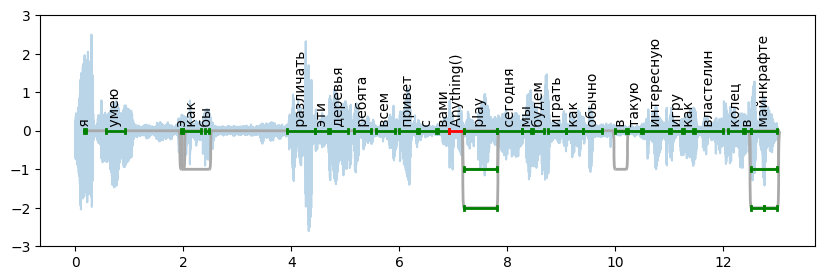

In [40]:
dataset = load_from_disk('tmp/multivariate/multivariant_v1_200')
sample = dataset[70] # type: ignore
waveform = Resample(22050, 16000, dtype=torch.float64)(
    torch.tensor(np.array(sample['audio']['array'])) # type: ignore
).numpy()
waveform = waveform[int(14.5*16_000):int(27.5*16_000)]

# np.random.seed(0)
# waveform += np.random.rand(len(waveform)) * 0.02 - 0.01

waveform += waveform[::-1] / 4

text = (
    'Я умею {э} {как бы} различать эти деревья, ребята. Всем привет, с вами'
    ' <*> {play | плэй | плей} , сегодня мы будем играть, как обычно, {в} такую'
    ' интересную игру как Властелин Колец в {Майнкрафте | Minecraft | Minecraft-е} .'
)

display(Audio(waveform, rate=16000)) # type: ignore

tokens = parse_multivariant_string(text)
fill_word_timings_inplace(model, waveform, tokens)

recording = Recording(transcription=text, transcription_words=tokens, waveform=waveform)

print(colorize_parsed_string(text, tokens)[0])

plt.figure(figsize=(10, 3)) # type: ignore
plt.plot( # type: ignore
    np.arange(len(waveform)) / 16_000,
    2.5 * waveform / waveform.max(),
    alpha=0.3,
    zorder=-1,
)
draw_timed_transcription(tokens)

plt.ylim(-3, 3) # type: ignore
plt.show() # type: ignore

In [41]:
asr = VoskStreaming(model_name='vosk-model-ru-0.42', chunk_length_sec=0.1)
asr.start_thread()

eval = default_evaluation_pipeline(recording, asr)

asr.stop_thread()

LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=13 max-active=7000 lattice-beam=6
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (VoskAPI:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /home/oleg/.cache/vosk/vosk-model-ru-0.42/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:279) Loading HCLG from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/HCLG.fst
LOG (VoskAPI:ReadDataFiles():model.cc:297) Loading words from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/words.txt
LOG (VoskAPI:ReadDataFiles():model.cc:30

Transcribing None/None/None
Transcribed None/None/None: я умею чтобы различать эти деревья ребятами всем привет я про пушку и [...]


In [42]:
print(' '.join(str(t.value) for t in eval.partial_alignments[-1].pred))

я умею чтобы различать эти деревья ребятами всем привет я про пушку и сегодня будем играть вы как обычно такое интересное


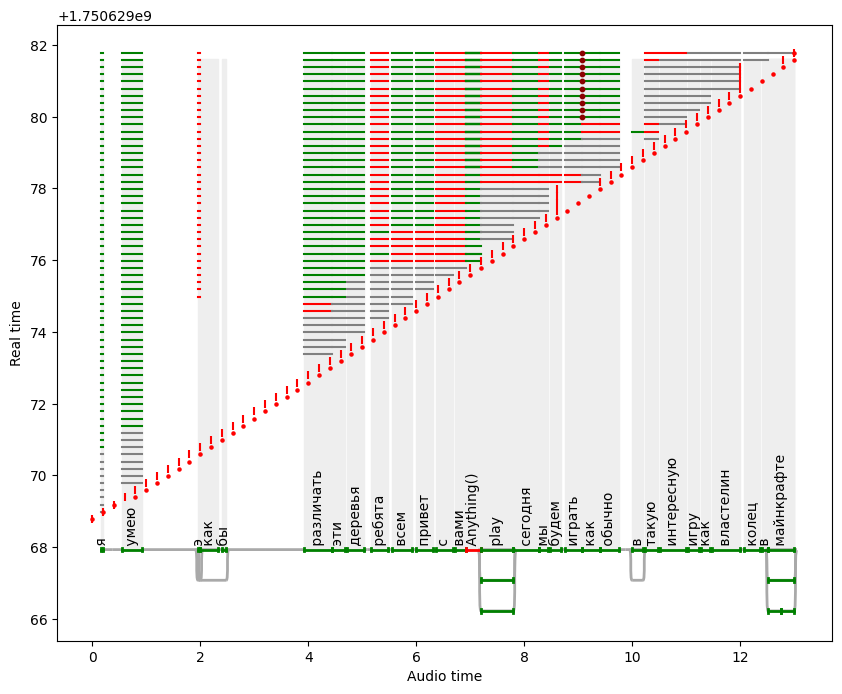

In [44]:
waveform = eval.recording.waveform

plt.figure(figsize=(10, 8)) # type: ignore

# y1, y2 = eval.start_timestamp, eval.finish_timestamp
# plt.plot( # type: ignore
#     np.arange(len(waveform)) / 16_000, # type: ignore
#     y1 - (y2 - y1) / 15 + 4.5 * waveform / waveform.max(), # type: ignore
#     alpha=0.2,
#     zorder=-1,
# )
partial_alignments_plot(eval)